# "Decouple_WD Parameter Deep Dive"
> "A deep dive into decouple_wd along with the code used to explore the concepts that come along with it"

- toc: true
- branch: master
- badges: true
- comments: true
- author: Kevin Bird
- categories: [no second turkey]

### Summary

If you don't plan to use weight decay (wd=0), you can safely ignore this parameter.  

If you do plan to use weight decay, but don't have any idea whether to decouple weight decay or not, use the default of True.  It works the same as l2_reg on sgd and doesn't have 

I don't currently know when you would want to use l2_reg vs weight decay unless trying to recreate historical results.  

* [If wd == 0: don't worry about decouple_wd](#weight_decay)
* [If decouple_wd is True, weight_decay is used, otherwise, l2_reg is used](#Look-at-SGD-definition)
* [weight_decay updates the value of params, l2_reg updates the param's gradients](#Weight_Decay-param-viewing)
* [weight_decay is directly tied to learning rate, l2_reg is not](#weight_decay)
* [Further Reading](#Further-Reading)

This is the first blog post in my [No Second Turkey](http://impartialderivative.com/no%20second%20turkey/2020/09/04/The-No-Second-Turkey-Learning-Concept.html) series.  ~~The concept that will be explored today is hyperparameters for SGD. Let's just dive right in:~~

Initially, my plan was to explore hyperparameters for SGD, but during the first hyperparameter that I looked at, I was derailed.  In this case, I felt like the exploration for this one hyperparameter was interesting enough to have its own post.  We will explore more hyperparameters in the future, but for now, I am going to publish a deep dive on just `decouple_wd`.  

In [66]:
from fastai.vision.all import *

In [9]:
SGD

<function fastai.optimizer.SGD(params, lr, mom=0.0, wd=0.0, decouple_wd=True)>

I am going to dig into `decouple_wd`.  It looks like it defaults to True, but what is that actually changing?  First, let's look at the sgd code: 

##### Look at SGD definition

In [12]:
SGD??

![sgd_ss](../images/sgd_ss.png)

Answers lead to more questions.  It looks like decouple_wd determines if `weight_decay` or `l2_reg` should be added to the callback list.  My initial hunch is that these are two different forms of weight decay, but let's dig into each of them and see how they both work.  

In [ ]:
cbs = [weight_decay] if decouple_wd else [l2_reg]

In [13]:
weight_decay??

In [ ]:
def weight_decay(p, lr, wd, do_wd=True, **kwargs):
    "Weight decay as decaying `p` with `lr*wd`"
    if do_wd and wd!=0: p.data.mul_(1 - lr*wd)

In [14]:
l2_reg??

In [ ]:
def l2_reg(p, lr, wd, do_wd=True, **kwargs):
    "L2 regularization as adding `wd*p` to `p.grad`"
    if do_wd and wd!=0: p.grad.data.add_(p.data, alpha=wd)

Looking at the arguments each of these take in, it looks like they take in the exact same information.  So it is really saying do I want to do thing 1 with these variables, or do I want to do thing 2?

First, I'm going to discect weight decay:

##### weight_decay

Part 1: `if do_wd and wd!=0:` So this first part is already super important for our problem.  Since we have wd set to 0 by default, neither of these functions will do anything in the beginning.  That kind of answers my initial question of whether decouple_wd should be True or False, but let's finish exploring this branch while we are going down it.  

Part 2: `p.data.mul_(1 - lr*wd)` This is a nice clean line of code, but what does it actually mean/do?

`p` represents our **params** (went and verified in [optimizer code](https://github.com/fastai/fastai/blob/master/fastai/optimizer.py#L82)).  

This is a Tensor and I can tell that because of how `p.data` is used. That is usually a giveaway that the parameter is having its gradients calculated.  (You'll get a big error if you try to work with p directly instead of p.data)  
  
`mul_` is saying multiply something and store it back into p.data.  [I'm going to look at up for sure mostly because I want to see what type of multiplication is used.](https://pytorch.org/docs/stable/generated/torch.mul.html).  The underscore runs the same function, but in pytorch, that is shorthand that says to store the results back into the tensor (similar to inplace=True in pandas if you are more familiar with that library). 
  
`1 - lr*wd` So when wd = 0, this would just multiple the params by 1 so there would be no affect which is also probably why it is skipped in that case.  Let's think about what happens in the alternative case though.  In the case where wd = 0.1 and lr = 1, this constant would be 0.9 so it would take every weight and cut it down.  So in practice, what does this do for us?  Our model can still tell the model to step back in the same direction.  I may have to think about this a bit more to understand why we would want to use weight decay.  For now, I am going to move on to l2_reg.  

##### L2_reg

L2_reg also checks if do_wd and wd!=0 similar to how weight decay works.  This is a bypass valve that says don't waste your calculations if wd is 0 or if you decide that you don't want any weight decay.  
  
`p.grad.data` is a lot different than p.data from weight_decay.  p.grad.data is actually looking at the gradient that was calculated.  
  
  
`add_` is then used to add a number into the gradients.  

`(p.data, alpha=wd)` 

I'm going to analyze this third part slightly out of order.  First I want to know what `alpha=wd` means:  
Torch's add function has an argument called alpha.  Alpha is a scalar that will be multiplied with the first argument.  In our case, `p.data`.  

So our model weights get multiplied by a scalar value and that value is added to the gradient.  Let's try to figure out what this is trying to accomplish.

So, weight_decay dampens down the model's params directly `1-lr*wd` amount.  My initial thoughts with this is that I don't like that `lr` is involved in this process.  I'm not sure if that is an important piece that I'm not understanding, but it is something that I would rather not have involved in my weight_decay parameter.  
  
l2_reg adds a small value associated with the weights directly to the gradient.  This isn't intuitive to me.  I'm curious why adding a value that is scaled with a small value `wd` would be helpful for our model.  If anything, it seems like it would just end up adding a small amount of noise.  This one doesn't use the learning rate which I like.

Since I don't feel like I currently have a good understanding of either weight_decay or l2_reg, I'm going to go do some searching and see if I can find some intuition around these two concepts.  

##### Further Reading

Here are a few links to explore from members of the fastai community: 
* https://blog.janestreet.com/l2-regularization-and-batch-norm/ (ChrisK)  
* https://arxiv.org/abs/1711.05101 (ilovescience)
* https://en.wikipedia.org/wiki/Tikhonov_regularization (ilovescience)

In [20]:
#from fastai.test_utils import *

I'm going to pull in the tst_param function which allows using a specific value and giving a specific gradient for the tensor.

##### Exploring single param

In [21]:
#shamelessly stolen from fastai docs: https://docs.fast.ai/optimizer#sgd_step
def tst_param(val, grad=None):
    "Create a tensor with `val` and a gradient of `grad` for testing"
    res = tensor([val]).float()
    res.grad = tensor([val/10 if grad is None else grad]).float()
    return res

In [39]:
p = tst_param(1, 0.2)

In [40]:
p

tensor([1.])

In [41]:
p.grad

tensor([0.2000])

In [42]:
weight_decay(p, 1., 0.1)

In [43]:
p

tensor([0.9000])

In [44]:
p.grad

tensor([0.2000])

I was going to cycle through some numbers, but instead I'm going to cycle through a bunch and plot the output of p and p.grad

In [52]:
learning_rate_l = [0.001, 0.01, 0.1, 1]
weight_decay_l = [0.001, 0.01, 0.1, 1]

In [56]:
learning_rate_grid, weight_decay_grid = np.meshgrid(learning_rate_l, weight_decay_l)

In [57]:
learning_rate_grid

array([[0.001, 0.01 , 0.1  , 1.   ],
       [0.001, 0.01 , 0.1  , 1.   ],
       [0.001, 0.01 , 0.1  , 1.   ],
       [0.001, 0.01 , 0.1  , 1.   ]])

In [58]:
weight_decay_grid

array([[0.001, 0.001, 0.001, 0.001],
       [0.01 , 0.01 , 0.01 , 0.01 ],
       [0.1  , 0.1  , 0.1  , 0.1  ],
       [1.   , 1.   , 1.   , 1.   ]])

In [63]:
for lr_list,wd_list in zip(learning_rate_grid, weight_decay_grid):
    ;

In [68]:
p_val = []
pg_val = []
for lr,wd in zip(lr_list, wd_list):
    p = tst_param(1, 0.2)
    weight_decay(p, lr, wd)
    p_val.append(p.data)
    pg_val.append(p.grad.data)
    print("lr:",lr,"wd:",wd, "-", p.data)
    print("lr:",lr,"wd:",wd, "-", p.grad.data)

lr: 0.001 wd: 1.0 - tensor([0.9990])
lr: 0.001 wd: 1.0 - tensor([0.2000])
lr: 0.01 wd: 1.0 - tensor([0.9900])
lr: 0.01 wd: 1.0 - tensor([0.2000])
lr: 0.1 wd: 1.0 - tensor([0.9000])
lr: 0.1 wd: 1.0 - tensor([0.2000])
lr: 1.0 wd: 1.0 - tensor([0.])
lr: 1.0 wd: 1.0 - tensor([0.2000])


In [69]:
p_val

[tensor([0.9990]), tensor([0.9900]), tensor([0.9000]), tensor([0.])]

In [70]:
pg_val

[tensor([0.2000]), tensor([0.2000]), tensor([0.2000]), tensor([0.2000])]

##### Weight_Decay param viewing

In [78]:
p_val = []
pg_val = []
for lr_list,wd_list in zip(learning_rate_grid, weight_decay_grid):
    for lr,wd in zip(lr_list, wd_list):
        p = tst_param(1, 0.2)
        weight_decay(p, lr, wd)
        p_val.append(p.data)
        pg_val.append(p.grad.data)
        print("param| ","lr:",lr,"wd:",wd, "-", p.data)
        print("grad | ","lr:",lr,"wd:",wd, "-", p.grad.data)

param|  lr: 0.001 wd: 0.001 - tensor([1.0000])
grad |  lr: 0.001 wd: 0.001 - tensor([0.2000])
param|  lr: 0.01 wd: 0.001 - tensor([1.0000])
grad |  lr: 0.01 wd: 0.001 - tensor([0.2000])
param|  lr: 0.1 wd: 0.001 - tensor([0.9999])
grad |  lr: 0.1 wd: 0.001 - tensor([0.2000])
param|  lr: 1.0 wd: 0.001 - tensor([0.9990])
grad |  lr: 1.0 wd: 0.001 - tensor([0.2000])
param|  lr: 0.001 wd: 0.01 - tensor([1.0000])
grad |  lr: 0.001 wd: 0.01 - tensor([0.2000])
param|  lr: 0.01 wd: 0.01 - tensor([0.9999])
grad |  lr: 0.01 wd: 0.01 - tensor([0.2000])
param|  lr: 0.1 wd: 0.01 - tensor([0.9990])
grad |  lr: 0.1 wd: 0.01 - tensor([0.2000])
param|  lr: 1.0 wd: 0.01 - tensor([0.9900])
grad |  lr: 1.0 wd: 0.01 - tensor([0.2000])
param|  lr: 0.001 wd: 0.1 - tensor([0.9999])
grad |  lr: 0.001 wd: 0.1 - tensor([0.2000])
param|  lr: 0.01 wd: 0.1 - tensor([0.9990])
grad |  lr: 0.01 wd: 0.1 - tensor([0.2000])
param|  lr: 0.1 wd: 0.1 - tensor([0.9900])
grad |  lr: 0.1 wd: 0.1 - tensor([0.2000])
param|  lr: 

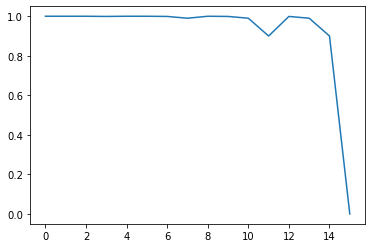

In [79]:
#param updates for weight_decay
plt.plot(p_val)

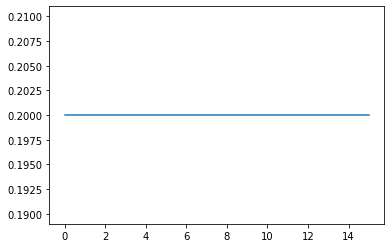

In [80]:
#gradient doesn't update for weight_decay
plt.plot(pg_val)

In [74]:
weight_decay??

In [72]:
p_val

[tensor([1.0000]),
 tensor([1.0000]),
 tensor([0.9999]),
 tensor([0.9990]),
 tensor([1.0000]),
 tensor([0.9999]),
 tensor([0.9990]),
 tensor([0.9900]),
 tensor([0.9999]),
 tensor([0.9990]),
 tensor([0.9900]),
 tensor([0.9000]),
 tensor([0.9990]),
 tensor([0.9900]),
 tensor([0.9000]),
 tensor([0.])]

In [73]:
pg_val

[tensor([0.2000]),
 tensor([0.2000]),
 tensor([0.2000]),
 tensor([0.2000]),
 tensor([0.2000]),
 tensor([0.2000]),
 tensor([0.2000]),
 tensor([0.2000]),
 tensor([0.2000]),
 tensor([0.2000]),
 tensor([0.2000]),
 tensor([0.2000]),
 tensor([0.2000]),
 tensor([0.2000]),
 tensor([0.2000]),
 tensor([0.2000])]

Key Takeaways
* The gradient doesn't change when doing weight decay
* LR and WD are tied to each other lr*wd

May be worth investigating adaptive learning rates with weight decay.  May end up with more weight decay than intended. 

Let's repeat that process for l2_reg

In [ ]:
l2_reg()

In [75]:
l2_reg??

l2_reg takes in lr as a parameter, but it doesn't actually do anything with it.  So my guess is that it only has it as a parameter to keep it consistent with weight decay.  

In [82]:
p_val = []
pg_val = []
for lr_list,wd_list in zip(learning_rate_grid, weight_decay_grid):
    for lr,wd in zip(lr_list, wd_list):
        p = tst_param(1, 0.2)
        l2_reg(p, lr, wd)
        p_val.append(p.data)
        pg_val.append(p.grad.data)
        print("lr:",lr,"wd:",wd, "-", p.data)
        print("lr:",lr,"wd:",wd, "-", p.grad.data)

lr: 0.001 wd: 0.001 - tensor([1.])
lr: 0.001 wd: 0.001 - tensor([0.2010])
lr: 0.01 wd: 0.001 - tensor([1.])
lr: 0.01 wd: 0.001 - tensor([0.2010])
lr: 0.1 wd: 0.001 - tensor([1.])
lr: 0.1 wd: 0.001 - tensor([0.2010])
lr: 1.0 wd: 0.001 - tensor([1.])
lr: 1.0 wd: 0.001 - tensor([0.2010])
lr: 0.001 wd: 0.01 - tensor([1.])
lr: 0.001 wd: 0.01 - tensor([0.2100])
lr: 0.01 wd: 0.01 - tensor([1.])
lr: 0.01 wd: 0.01 - tensor([0.2100])
lr: 0.1 wd: 0.01 - tensor([1.])
lr: 0.1 wd: 0.01 - tensor([0.2100])
lr: 1.0 wd: 0.01 - tensor([1.])
lr: 1.0 wd: 0.01 - tensor([0.2100])
lr: 0.001 wd: 0.1 - tensor([1.])
lr: 0.001 wd: 0.1 - tensor([0.3000])
lr: 0.01 wd: 0.1 - tensor([1.])
lr: 0.01 wd: 0.1 - tensor([0.3000])
lr: 0.1 wd: 0.1 - tensor([1.])
lr: 0.1 wd: 0.1 - tensor([0.3000])
lr: 1.0 wd: 0.1 - tensor([1.])
lr: 1.0 wd: 0.1 - tensor([0.3000])
lr: 0.001 wd: 1.0 - tensor([1.])
lr: 0.001 wd: 1.0 - tensor([1.2000])
lr: 0.01 wd: 1.0 - tensor([1.])
lr: 0.01 wd: 1.0 - tensor([1.2000])
lr: 0.1 wd: 1.0 - tensor([1.

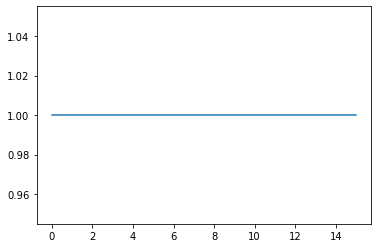

In [83]:
plt.plot(p_val)

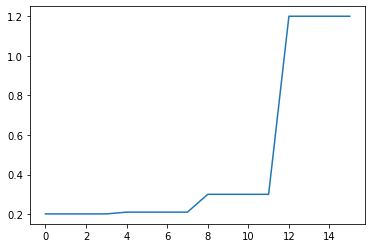

In [84]:
plt.plot(pg_val)

Key Takeaways l2_reg
* The gradient is updated using wd*param (higher param values would have a higher weight decay penalty
* param values remain unchanged when using l2_reg

If I'm understanding the difference between l2_reg and weight_decay, l2_reg directly modifies the param gradient's by using a hyper parameter `wd` and the param values themselves.  
  
Whereas weight decay also has a `wd` parameter, but it uses that parameter alongside the `lr` to create a dampener on the weights.  So the higher the learning rate, the more weight_decay will dampen the params and same with wd.  